In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [2]:
# Parameters for the synthetic return table
start_date = "2010-01-01"
end_date = "2019-12-31"
dates = pd.date_range(start=start_date, end=end_date, freq="B")  # Business days
n_days = len(dates)

# Daily returns
asset_a_returns = np.full(n_days, 0.002)  # 0.2% daily
asset_b_returns = np.full(n_days, 0.001)  # 0.1% daily

# Combine into a DataFrame
returns = pd.DataFrame({
    "AssetA": asset_a_returns,
    "AssetB": asset_b_returns,
}, index=dates)

print("Test Returns Table (Preview):")
print(returns.head())
returns

Test Returns Table (Preview):
            AssetA  AssetB
2010-01-01   0.002   0.001
2010-01-04   0.002   0.001
2010-01-05   0.002   0.001
2010-01-06   0.002   0.001
2010-01-07   0.002   0.001


,AssetA,AssetB
2010-01-01,0.002,0.001
2010-01-04,0.002,0.001
2010-01-05,0.002,0.001
2010-01-06,0.002,0.001
2010-01-07,0.002,0.001
...,...,...
2019-12-25,0.002,0.001
2019-12-26,0.002,0.001
2019-12-27,0.002,0.001
2019-12-30,0.002,0.001


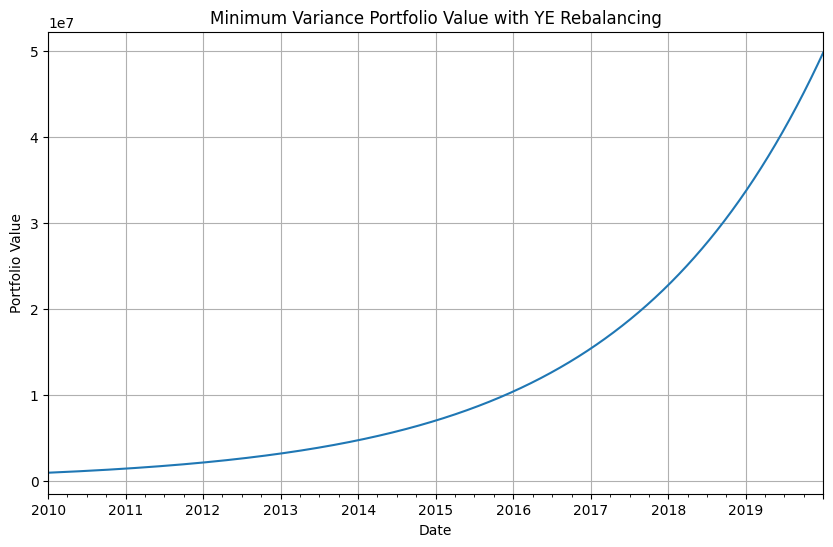

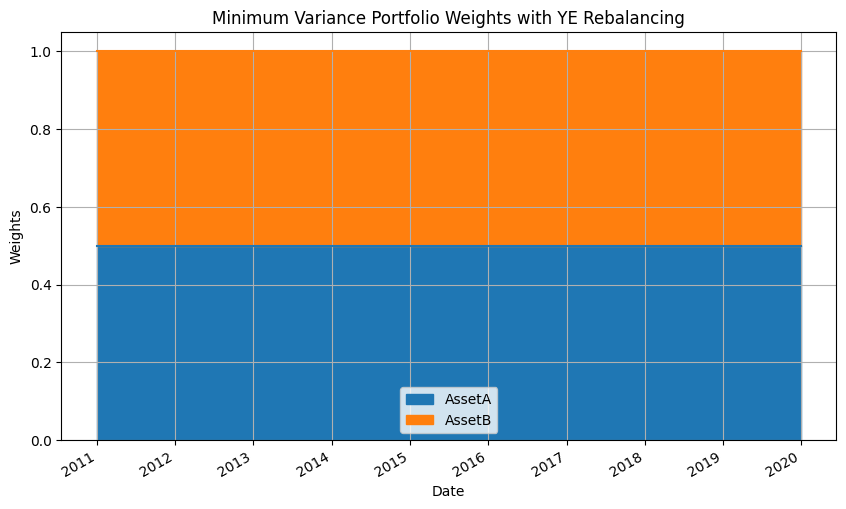

In [3]:
#### Min Var Portfolio Construction #### ver. 2.0

# Helper to calculate portfolio variance
def calc_portfolio_variance(w, covariance_matrix):
    # Portfolio variance = w^T * Covariance Matrix * w
    return np.dot(w.T, np.dot(covariance_matrix, w))

# Helper for weight constraint
def total_weight_constraint(w):
    return np.sum(w) - 1  # Total weights must sum to 1

# Portfolio optimization function to minimize variance
def min_variance_optimizer(cov_matrix, w0, bounds, cons):
    #cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    #bounds = [(0, 1) for _ in range(len(returns.columns))]
    # Use scipy's minimize function to find the weights that minimize the portfolio variance
    res = minimize(calc_portfolio_variance, w0, args=(cov_matrix,), bounds=bounds, constraints=cons, method='SLSQP', options = {'ftol':1e-8}) #ftol is a very important variable, test!!!
    return res

# Main function to calculate minimum variance portfolio over time
def min_variance_portfolio(returns, rebalance_frequency, initial_investment=1e6):

    rebal_dates = returns.resample(rebalance_frequency).last().index
    aligned_rebal_dates = returns.index.get_indexer(rebal_dates, method='nearest')
    rebal_dates = returns.index[aligned_rebal_dates]

    portfolio_value = pd.Series(index=returns.index, dtype=float)
    portfolio_value.iloc[0] = initial_investment

    portfolio_weights = pd.DataFrame(index=rebal_dates, columns=returns.columns, dtype=float)

    n_assets = returns.shape[1]
    w0 = np.ones(n_assets) / n_assets  # initial: 1/n
    bounds = [(0, 1) for _ in range(n_assets)]
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)

    if len(rebal_dates) > 0:
        portfolio_weights.iloc[0] = w0

    # 5) Rebalancing loop
    for i in range(len(rebal_dates)):
        this_rebal_date = rebal_dates[i]

        # (A) If not the first rebal date, compute new weights:
        if i > 0:
            lookback_days = 180  # ~180 trading days (6 months), just an example
            cov_start = this_rebal_date - pd.Timedelta(days=lookback_days)
            cov_data = returns.loc[cov_start:this_rebal_date]

            if cov_data.isna().any().any() or len(cov_data) < 2:
                print(f"Skipping rebal {this_rebal_date} due to insufficient data.")
            else:
                # Optimize min variance
                cov_matrix = cov_data.cov().values
                res = min_variance_optimizer(cov_matrix, w0, bounds, cons)
                if not res.success:
                    print(f"Optimization failed at {this_rebal_date}")
                else:
                    optimal_weights = res.x
                    assert np.isclose(np.sum(optimal_weights), 1), "Weights do not sum to 1."
                    assert all(0 <= w <= 1 for w in optimal_weights), "Weights are out of [0,1] bounds."
                    w0 = optimal_weights
                    portfolio_weights.loc[this_rebal_date] = w0


        if i == 0:
            prev_rebal_date = portfolio_value.index[0]
        else:
            prev_rebal_date = rebal_dates[i - 1]

        daily_index_slice = portfolio_value.index[(portfolio_value.index >= prev_rebal_date) & (portfolio_value.index <= this_rebal_date)]

        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    if len(rebal_dates) > 0:
        final_rebal = rebal_dates[-1]
        daily_index_slice = portfolio_value.loc[final_rebal:].index
        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)


    return portfolio_value, portfolio_weights

#### Actual Fuction Call ####

rebalance_frequency = 'YE'  # ME = monthly, QE = quarterly, YE = yearly
portfolio_value, portfolio_weights = min_variance_portfolio(returns, rebalance_frequency)

# Plot the portfolio value over time
portfolio_value.plot(figsize=(10, 6))
plt.title(f'Minimum Variance Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Plot the portfolio weights over time
portfolio_weights.plot(figsize=(10, 6), kind='area', stacked=True)
plt.title(f'Minimum Variance Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


In [4]:
#### Min Var Portfolio Analytics ####

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_minvar = portfolio_value.resample('ME').ffill()
monthly_returns_minvar = monthly_portfolio_value_minvar.pct_change().dropna()

# 2) Full sample annualized monthly volatility
full_sample_monthly_vol = monthly_returns_minvar.std()
annualized_vol = full_sample_monthly_vol * np.sqrt(12)

# 3) Total return & Geo means
initial_val = portfolio_value.iloc[0]
final_val = portfolio_value.iloc[-1]
total_return_minvar = (final_val - initial_val) / initial_val

n_months = len(monthly_returns_minvar)
geo_avg_monthly_return_minvar = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_yearly_return_minvar = (1 + geo_avg_monthly_return_minvar) ** 12 - 1

# 5) Sharpe Ratio
arithmetic_monthly_return = monthly_returns_minvar.mean()  # Arithmetic mean of monthly returns
annualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualized arithmetic return
sharpe_ratio_minvar = annualized_arithmetic_return / annualized_vol

# 6) Monthly 99% VaR
VaR_99_minvar = monthly_returns_minvar.quantile(1 - 0.99)

# 7) Print results
print("### Minimum Variance Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol:.4f}")
print(f"Total return: {total_return_minvar * 100:.2f}%")

print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_minvar * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_minvar * 100:.2f}%")

print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_minvar:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_minvar:.4f}")


### Minimum Variance Portfolio Analytics ###
Full-sample annualized monthly volatility: 0.0052
Total return: 4877.78%
Geometric avg monthly return (CAGR basis): 3.34%
Geometric avg yearly return (CAGR basis): 48.30%
Sharpe Ratio (Arithmetic Return / Annualized Vol): 76.44
Monthly 99% Value at Risk (VaR): 0.0304
